# Electricity_Forecasting
參考文件: https://docs.google.com/document/d/11G_SqvtPEQD4cqCEfBCpBS4L8BeiVIwlNoXYy7oSdKM/edit  

In [1]:
import pandas as pd
import numpy as np
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent kernel from dying when fitting
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

## 參數

In [2]:
n_days = list(range(2, 201)) # number of days needed for prediction
init_n_days = 145
n_tests = 30 # numbers of days reserved for testing
start_offset = 400

## 整理　dataset

In [3]:
'''
load data
'''

raw_data = []
raw_data = pd.DataFrame(raw_data)

file = '近三年每日尖峰備轉容量率.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(萬瓩)']]
raw_data_new.columns=['date','capacity']
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])

# change datetime format
'''
for index in range(len(raw_data_new['date'])):
    index_time = str(raw_data_new['date'][index]).split('.')[-1][1:]
    # print(index_time)
    time_change = datetime.strptime(index_time,"%Y%m%d")
    raw_data_new['date'][index] = time_change
    raw_data_new['capacity'][index] /= 10 
'''

raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data, raw_data_new])

file =  '台灣電力公司_本年度每日尖峰備轉容量率.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['date','capacity']]
raw_data_new['date'] = pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data,raw_data_new])

'''split training set and testing set'''
train = raw_data[start_offset:-n_tests]
test = raw_data[-n_tests:]

# train.set_index('date',inplace=True)
# test.set_index('date',inplace=True)
# print("train:\n",train)
# print("test:\n",test)

<AxesSubplot:xlabel='date'>

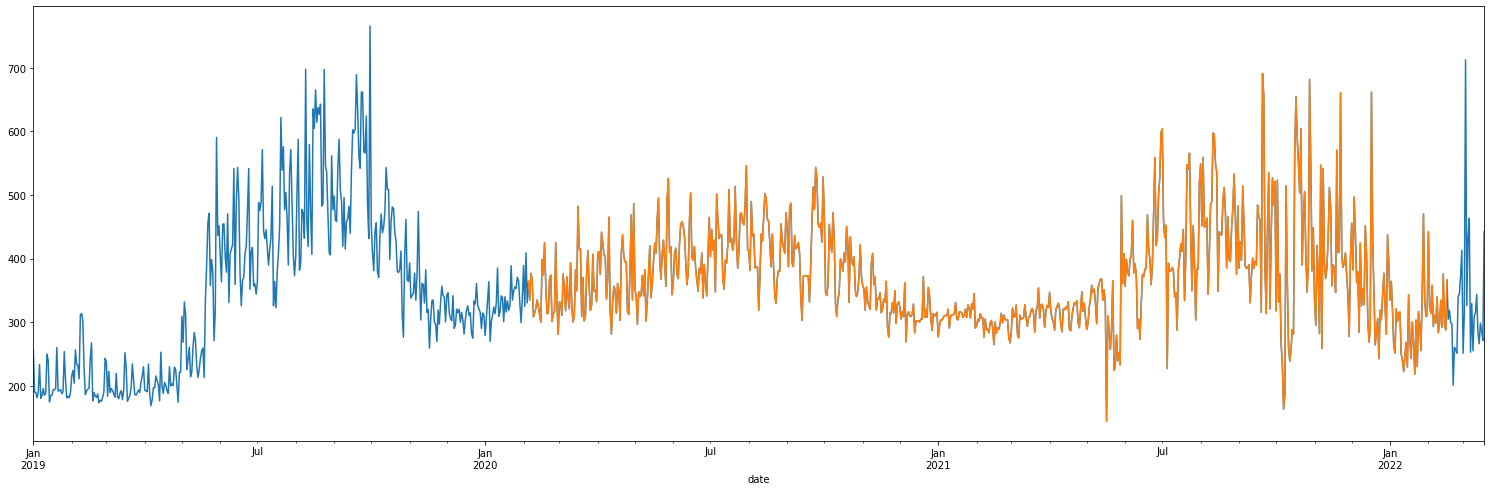

In [4]:
raw_data.set_index('date',inplace=True)
raw_data['capacity'].plot(label='first_data', figsize=(26,8))
# raw_data = raw_data.reset_index(level=0)
train_tmp = train[:]
train_tmp.set_index('date',inplace=True)
train_tmp['capacity'].plot(label='first_data', figsize=(26,8))

## xgtboost 演算法
eXtreme Gradient Boosting

### 使用當天的日期、前 n 天的 capacity

#### Initialization

In [5]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

train.tail()

,date,capacity,year,month,day,day_of_week
42,2022-02-12,292.1,2022,2,12,5
43,2022-02-13,375.7,2022,2,13,6
44,2022-02-14,296.6,2022,2,14,0
45,2022-02-15,287.7,2022,2,15,1
46,2022-02-16,366.5,2022,2,16,2


#### Training / Fitting

In [6]:
def add_day_of_data_from_record(X, raw_data, i): # lists are mutable
#     X.extend([raw_data.iloc[i]['year'], raw_data.iloc[i]['month'], raw_data.iloc[i]['day'], raw_data.iloc[i]['day_of_week']])
    X.extend([raw_data.index[i], raw_data.iloc[i]['day_of_week']])


def generate_training_data(training_data, n_days):
    capacity_mean = round(float(training_data['capacity'].mean()), 1)
    X_train_list = []
    Y_train_list = []
    for i in range(n_days, len(training_data['date'])):
        X = []
        Y = []
        # add today info
        add_day_of_data_from_record(X, training_data, i)
        # add last n days capacity
        for last_day_index in range(1, n_days + 1):
            last_day = i - last_day_index 
            X.append(training_data.iloc[last_day]['capacity'])
    #         if last_day >= 0:
    #             X.append(training_data.iloc[last_day]['capacity'])
    #         else:
    #             X.append(capacity_mean)
        # add today capacity for verification
        Y.append(training_data.iloc[i]['capacity'])
        X_train_list.append(X)
        Y_train_list.append(Y)

    '''
    change list to np-array
    '''
    X_train_list = np.array(X_train_list)
    Y_train_list = np.array(Y_train_list)
    
    return X_train_list, Y_train_list

X_train_list, Y_train_list = generate_training_data(train, init_n_days)

In [7]:
xgb_model.fit(X_train_list, Y_train_list, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
def train_predictions_rmse(X_train_list):
    y_train_pred = xgb_model.predict(X_train_list)
    rmse=mean_squared_error(Y_train_list, y_train_pred, squared=False)
    return rmse, y_train_pred

rmse, y_train_pred = train_predictions_rmse(X_train_list)
print(len(y_train_pred), 'predictions')
print('RMSE:', rmse)

598 predictions
RMSE: 0.015050253985735597


In [9]:
result_df = train[['date','capacity']]
result_df = result_df.iloc[len(train) - len(y_train_pred):, :]
result_df['capacity_predict'] = y_train_pred

result_df.head()

,date,capacity,capacity_predict
545,2020-06-29,401.3630,401.382263
546,2020-06-30,464.6470,464.622437
547,2020-07-01,402.9545,402.955536
548,2020-07-02,445.7685,445.763672
549,2020-07-03,413.0985,413.110382


In [10]:
result_df.set_index('date',inplace=True)
result_df.head()

,capacity,capacity_predict
date,,
2020-06-29,401.3630,401.382263
2020-06-30,464.6470,464.622437
2020-07-01,402.9545,402.955536
2020-07-02,445.7685,445.763672
2020-07-03,413.0985,413.110382


<AxesSubplot:xlabel='date'>

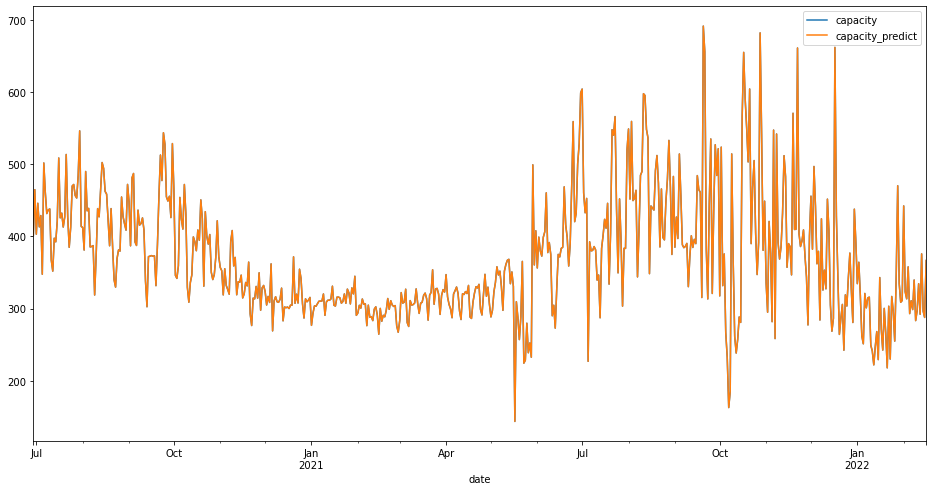

In [11]:
result_df.plot(label='first_data', figsize=(16,8))

In [12]:
result_df = result_df.reset_index(level=0)
result_df.head()

,date,capacity,capacity_predict
0,2020-06-29,401.3630,401.382263
1,2020-06-30,464.6470,464.622437
2,2020-07-01,402.9545,402.955536
3,2020-07-02,445.7685,445.763672
4,2020-07-03,413.0985,413.110382


#### Testing XGBoost Model

In [13]:
'''
prepare test data
'''

def generate_testing_data_and_predictions(training_data, testing_data, n_days):
    Y_test_list =[]
    y_test_pred_list =[]
    capacity_mean = round(float(training_data['capacity'].mean()),1)

    for i in range(len(testing_data['date'])):
        X_test_list =[]
        X = []
        Y = []
        # add today info
        add_day_of_data_from_record(X, testing_data, i)
        # add data from prev n days
        for last_day_index in range(1, n_days + 1):
            last_day = i - last_day_index
            # if not in given data, use real data
            if last_day >= 0:
                X.append(testing_data.iloc[last_day]['capacity'])
            #       X.append(y_test_pred_list[last_day])
            # if in given data, take in from training data list
            else:
                X.append(training_data.iloc[last_day]['capacity'])
                # print(training_data.iloc[last_day]['capacity'])
            '''
            The original code is `training_data.iloc[-last_day]['caoacity']` but since last_day is already negative, the minus operated isn't needed.
            '''
        # save the correct answer for later check
        Y.append(testing_data.iloc[i]['capacity'])
        X_test_list.append(X)
        Y_test_list.append(Y)
        # predict the result, and add it to y_test_pred_list
        # it will be needed in the next iteration on
        y_test_pred = xgb_model.predict(X_test_list)
        y_test_pred_list.append(round(y_test_pred[0],1))

    # change list to np array
    X_test_list = np.array(X_test_list)
    Y_test_list = np.array(Y_test_list)
    return X_test_list, Y_test_list, y_test_pred_list
    
X_test_list, Y_test_list, y_test_pred_list = generate_testing_data_and_predictions(train, test, init_n_days)

In [14]:
'''
test the result
'''
def test_predictions_rmse(Y_test_list, y_test_pred_list):
    return mean_squared_error(Y_test_list, y_test_pred_list, squared=False)

print(len(y_test_pred_list))
rmse = test_predictions_rmse(Y_test_list, y_test_pred_list)
print('RMSE =', rmse)

30
RMSE = 99.07023920523942


In [15]:
test_result_df = test[['date','capacity']]
test_result_df['capacity_predict'] = y_test_pred_list
test_result_df.head()

,date,capacity,capacity_predict
47,2022-02-17,304.3,317.000000
48,2022-02-18,318.4,340.700012
49,2022-02-19,298.9,339.700012
50,2022-02-20,297.2,290.700012
51,2022-02-21,200.6,312.200012


<AxesSubplot:xlabel='date'>

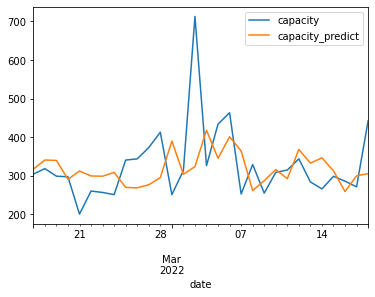

In [16]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data') # , figsize=(16,8)

##### Master Cell: Test Different `n_days` values

In [17]:
min_rmse = rmse
best_n_days = n_days[0]
for n in n_days:
    X_train_list, Y_train_list = generate_training_data(train, n)
    xgb_model.fit(X_train_list, Y_train_list, verbose=False)
    X_test_list, Y_test_list, y_test_pred_list = generate_testing_data_and_predictions(train, test, n)
    rmse = test_predictions_rmse(Y_test_list, y_test_pred_list)
    if rmse < min_rmse:
        best_n_days = n
        min_rmse = rmse
    print(n, ':', rmse)

print("Best n_days: ", best_n_days)
print("Minimum RMSE: ", min_rmse)

2 : 101.17235298933937
3 : 96.37281089059891
4 : 94.62521767664933
5 : 91.80305672913556
6 : 95.63097314073751
7 : 98.2878134758974
8 : 96.00193692648152
9 : 97.38283788022828
10 : 96.35940698179685
11 : 103.80395680828389
12 : 92.304913336628
13 : 94.73833964975952
14 : 93.40310105462873
15 : 90.34985115583696
16 : 101.7809961687924
17 : 94.03888234112458
18 : 94.60514409559029
19 : 98.29834113096733
20 : 94.20348588674727
21 : 99.28860187965304
22 : 104.28423877708539
23 : 101.74652832007212
24 : 99.99864373144439
25 : 97.00362141270523
26 : 97.59302472896717
27 : 100.66113443528849
28 : 100.01454233208894
29 : 105.44326305629212
30 : 103.48421799906514
31 : 97.80031773261445
32 : 98.52808444250593
33 : 99.4012627608534
34 : 100.65744375270438
35 : 94.75194375922197
36 : 94.27628923388248
37 : 94.82700248016617
38 : 94.58717731998716
39 : 100.78298031339271
40 : 104.66107585202182
41 : 101.69996824991118
42 : 99.9349410508181
43 : 103.90239449163556
44 : 101.8652309335857
45 : 107.67

### 只用 當天日期


In [18]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

In [19]:
train.tail()

,date,capacity,year,month,day,day_of_week
42,2022-02-12,292.1,2022,2,12,5
43,2022-02-13,375.7,2022,2,13,6
44,2022-02-14,296.6,2022,2,14,0
45,2022-02-15,287.7,2022,2,15,1
46,2022-02-16,366.5,2022,2,16,2


#### train the xgb boost model

In [20]:
X_train_list =[]
Y_train_list =[]
for i in range(len(train['date'])):
      X = []
      Y = []
      # only add today info
      X.extend([train.iloc[i]['year'],train.iloc[i]['month'],train.iloc[i]['day'],train.iloc[i]['day_of_week']])
      # save the correct answer 
      Y.append(train.iloc[i]['capacity'])
      X_train_list.append(X)
      Y_train_list.append(Y)
# change list to np array
X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)

In [21]:
xgb_model.fit(X_train_list, Y_train_list)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
y_train_pred = xgb_model.predict(X_train_list)
print(len(y_train_pred))
rmse=mean_squared_error(Y_train_list, y_train_pred, squared=False)
print('RMSE =', rmse)

743
RMSE = 6.728199552394763


In [23]:
result_df = train[['date','capacity']]
result_df = result_df.iloc[len(train) - len(y_train_pred):, :]
result_df['capacity_predict'] = y_train_pred
result_df.head()

,date,capacity,capacity_predict
400,2020-02-05,364.26,363.325073
401,2020-02-06,334.69,334.144318
402,2020-02-07,376.72,372.596497
403,2020-02-08,366.02,364.776062
404,2020-02-09,308.44,311.444458


In [24]:
result_df.set_index('date',inplace=True)

In [25]:
result_df.head()

,capacity,capacity_predict
date,,
2020-02-05,364.26,363.325073
2020-02-06,334.69,334.144318
2020-02-07,376.72,372.596497
2020-02-08,366.02,364.776062
2020-02-09,308.44,311.444458


<AxesSubplot:xlabel='date'>

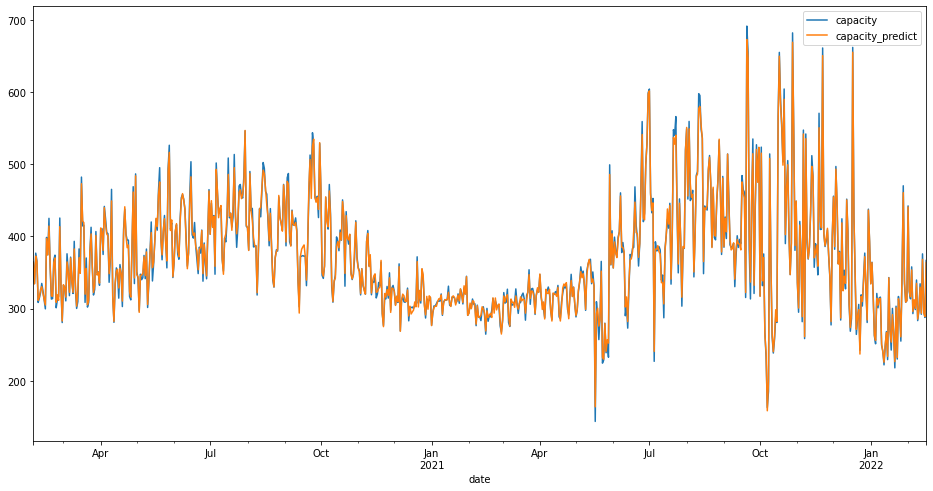

In [26]:
result_df.plot(label='first_data', figsize=(16,8))

In [27]:
result_df = result_df.reset_index(level=0)
result_df.head()

,date,capacity,capacity_predict
0,2020-02-05,364.26,363.325073
1,2020-02-06,334.69,334.144318
2,2020-02-07,376.72,372.596497
3,2020-02-08,366.02,364.776062
4,2020-02-09,308.44,311.444458


#### test the xgb boost model

In [28]:
X_test_list =[]
Y_test_list =[]

for i in range(len(test['date'])):
  X = []
  Y = []
  # only today info
  X.extend([test.iloc[i]['year'],test.iloc[i]['month'],test.iloc[i]['day'],test.iloc[i]['day_of_week']])
  # save correct answer for check
  Y.append(test.iloc[i]['capacity'])
  X_test_list.append(X)
  Y_test_list.append(Y)
X_test_list = np.array(X_test_list)
Y_test_list = np.array(Y_test_list)

In [29]:
y_test_pred = xgb_model.predict(X_test_list)
print(len(y_test_pred), 'predictions')
rmse=mean_squared_error(Y_test_list, y_test_pred, squared=False)
print('RMSE =', rmse)

30 predictions
RMSE = 99.7581641741821


In [30]:
test_result_df = test[['date','capacity']]
test_result_df['capacity_predict'] = y_test_pred
test_result_df.head()

,date,capacity,capacity_predict
47,2022-02-17,304.3,307.139130
48,2022-02-18,318.4,298.352203
49,2022-02-19,298.9,304.158813
50,2022-02-20,297.2,312.552826
51,2022-02-21,200.6,292.415558


<AxesSubplot:xlabel='date'>

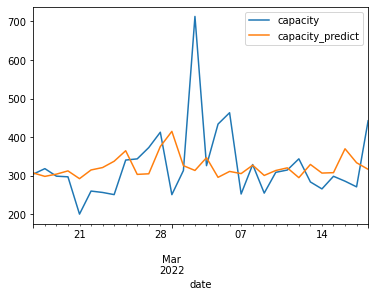

In [31]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data') # , figsize=(16,8)

## ARIMA 整合移動平均自我迴歸模型

時間序列演算法 參考資料：https://blog.csdn.net/weixin_43861350/article/details/110008352#ARIMA__25

### 複雜版本
https://adaptable-haze-butterfly-551.medium.com/arima%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%A8%A1%E5%9E%8Bpython%E6%87%89%E7%94%A8-%E9%8A%85%E5%83%B9%E6%A0%BC%E9%A0%90%E6%B8%AC-%E4%B8%80-4f91693e3ec6  

#### ETS Decomposition Models(error-trend-seasonality)

NameError: name 'data_cat' is not defined

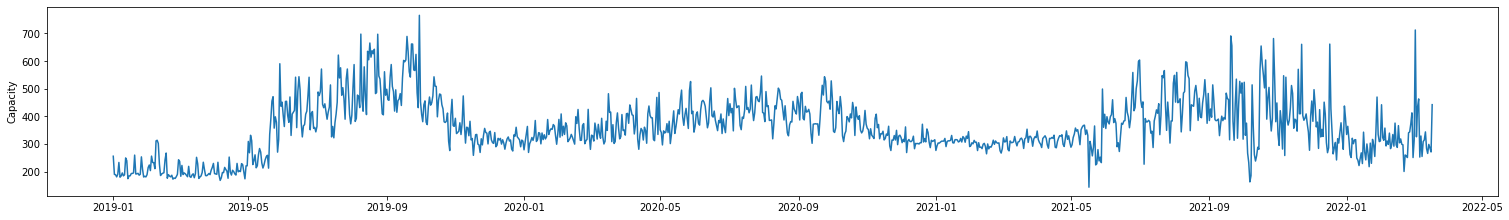

In [32]:
arima_data = raw_data['capacity']
# result = sm.tsa.seasonal_decompose(arima_data) # , freq=3
result = seasonal_decompose(arima_data, model="multiplicative") # , freq=3
plt.figure(figsize=(26,16))
plt.subplot(4,1,1)
plt.plot(result.observed, label="Copper Future")
plt.ylabel("Capacity")
plt.xticks(data_cat.index[::15], rotation=20) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,4)
plt.scatter(data_cat.index,result.resid)
plt.ylabel("Resid")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

#### 平穩性檢驗

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(arima_data)

In [ ]:
#一階差分 lags:1,12
diff_1 = arima_data - arima_data.shift(1) 
diff_1 = diff_1.dropna()
diff_1.head()
diff_1.plot(figsize=(16,8), label="diff_1")
plt.legend()

adf_test(diff_1)

#### 畫ACF圖與PACF圖
幫助我們判斷模型ARIMA(p, d, q)參數的選擇

In [ ]:
#correlogram
f = plt.figure(facecolor='white', figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(arima_data, lags=24, ax=ax2)
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

In [ ]:
def arima_AIC(data, p=4, d=3, q=4):
    best_AIC =["pdq",10000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):            
                model = ARIMA(data, order=(i,j,k))
                fitted = model.fit() #disp=-1
                AIC.append(fitted.aic)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k}):AIC={fitted.aic}")
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})"
                    best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.show()
arima_AIC(arima_data, 4,2,3)

In [ ]:
#data spilt
period = 15
title = f'ARIMA(3,1,2) for Forecasting {period} Periods'
L = len(arima_data)
x_train = arima_data[:(L-period)]
x_test = arima_data[-period:]
#Build Model 
model = ARIMA(x_train, order=(3, 1, 2)) 
fitted = model.fit()# disp=-1
#Forecast
fc, se, conf,_,_,_,_,_,_,_,_,_,_,_,_ = fitted.forecast(period, alpha=0.05) # 95% conf
#Make as pandas series
fc_series = pd.Series(fc, index=x_test.index)
#Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xticks(data_cat.index[::30], rotation=45)
plt.title(title)
plt.ylabel("Copper price")
plt.legend(loc='upper right', fontsize=8)
plt.show()
#Results
print(f"Mean Absolute Error : {mean_absolute_error(fc_series,x_test)}")
print(f"Mean Squared Error : {mean_squared_error(fc_series,x_test)}")
print("===========================") 
print("fc_series:",fc_series)
print("===========================")
print("Copper price:",x_test)

### 簡易版 ARIMA 試驗
參考資料:  
- https://www.itread01.com/content/1544268486.html
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [ ]:
arima_data = data_cat['capacity']
arima_data.head()

#### 只使用原始資料

In [ ]:
test_count = 14

In [ ]:
def predict(data,test_count):
    train, test = data[0:-test_count], data[-test_count:]
	# all the history data
	history = [x for x in train]
	predictions = []
	for t in range(test_count):
		# get the model from history data
		model = ARIMA(history, order=(3,1,2))
		# predict today capacity
		model_fit = model.fit()
		output = model_fit.forecast()
		yhat = output[0]
		# save result to predictions for later check correctness
		predictions.append(yhat)
		# save result to history for next day capacity prediction
		history.append(yhat)

		##  save predicted info to a new row in train dataframe
		# someday = train[-1:].index.values[0]
		# someday= pd.to_datetime(someday,format = '%Y-%m-%d %H:%M:%S')
		# onemore_date = someday + timedelta(days=1)
		# train.loc[onemore_date] = [round(yhat,1)]
		# print('predicted=%f, expected=%f' % (yhat, test[t]))

	predictions_df = pd.DataFrame(predictions,columns=['predicted_capacity'])
	# calculate the error by mse
	error = mean_squared_error(test, predictions_df)
	print('Test MSE: %.3f' % error)

	# combine the correct answer (in test), and predicted answer (in predictions_df) 
	# to result
	test = test.reset_index(level=0)
	result = pd.concat([test,predictions_df],axis=1)

	return result

In [ ]:
result = predict(arima_data,test_count)
result = result.set_index('date')
result.head()
plt.xticks(rotation=25)
plt.plot(result)

#### 先使用一階差分

In [ ]:
test_count = 14

In [ ]:
def diff_predict(data,test_count):
    #一階差分 lags:1,12
    diff_1 = data.diff()
    diff_1 = diff_1.dropna()
    # all the history data after diff
    train, test = diff_1[0:-test_count], diff_1[-test_count:]
    history = [x for x in train]
    predictions = []

    for t in range(test_count):
        # get the model from history data
        model = ARIMA(history, order=(3,1,2))
        # predict the result (diff)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        # save result to predictions for later check correctness
        predictions.append(yhat)
        # save result to history for next day capacity diff prediction
        history.append(yhat)

        # # save predicted info to a new row in train dataframe
        # someday = train[-1:].index.values[0]
        # someday= pd.to_datetime(someday,format = '%Y-%m-%d %H:%M:%S')
        # onemore_date = someday + timedelta(days=1)
        # train.loc[onemore_date] = [round(yhat,1)]
        # print('predicted=%f, expected=%f' % (yhat, test[t]))

    # change diff to real capacity (need last capacity to calculate)
    predictions_df = pd.DataFrame(predictions,columns=['predicted_capacity'])
    ## first one need training dataset last one to calculate
    predictions_df.iloc[0]['predicted_capacity'] = predictions_df.iloc[0]['predicted_capacity'] + data[-len(test)-1]
    ## second and so on need front predicted_capacity
    for t in range(1,len(test)):
        predictions_df.iloc[t]['predicted_capacity'] = predictions_df.iloc[t-1]['predicted_capacity'] + predictions_df.iloc[t]['predicted_capacity']

    # save real capacity to real_test 
    # for later check correctness
    real_test = data[-len(test):]
    error = mean_squared_error(real_test, predictions_df)
    print('Test MSE: %.3f' % error)
    real_test = real_test.reset_index(level=0)

    # combine the correct answer (in real_test), and predicted answer (in predictions_df) 
	# to result
    result = pd.concat([real_test,predictions_df],axis=1)
    
    return result

In [ ]:
arima_data.tail()

In [ ]:
result = diff_predict(arima_data,test_count)
result = result.set_index('date')
result.head()
plt.xticks(rotation=25)
plt.plot(result)

In [ ]:
result.tail()

## SARIMA 模型


## 